<a href="https://colab.research.google.com/github/uandhafb/postcards-from-my-jungle/blob/main/image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets:

1. Birds: "yashikota birds-525-species-image-classification"
image_size = 64, num_epochs = 21, dataset = 10000, batch_size = 16

2. Whales: "mlnomad/imnet1k_grey_whale_gray_whale_devilfish_Eschrichtius_gibbosus_Eschrichtius_robustus" image_size = 64, num_epochs = 31, dataset = 1000, batch_size = 8

3. Giraffes: "Inan404/synthetic-zebra-giraffe-03" image_size = 64, num_epochs = 51, dataset = 1000, batch_size = 8

4. Elephants: "rmokady/SDIP_elephant" image_size = 64, num_epochs = 41, dataset = 8192, batch_size = 16

5. Polar Bears: "mlnomad/imnet1k_ice_bear_polar_bear_Ursus_Maritimus_Thalarctos_maritimus" image_size = 64, num_epochs = 19, dataset = 1000, batch_size = 8

6. Komodo Dragons: "mlnomad/imnet1k_Komodo_dragon_Komodo_lizard_dragon_lizard_giant_lizard_Varanus_komodoensis" image_size = 64, num_epochs = 27, dataset = 1000, batch_size = 8

7. Horses: "charchits7/horse2zebra" image_size = 64, num_epochs = 17, dataset = 400, batch_size = 8

8. Anemone: "mlnomad/imnet1k_sea_anemone_anemone" image_size = 64, num_epochs = 45, dataset = 1000, batch_size = 8

9. Spider Monkey: "mlnomad/imnet1k_spider_monkey_Ateles_geoffroyi" image_size = 64, num_epochs = 13, dataset = 1000, batch_size = 8

10. Penguins: "mlnomad/imnet1k_king_penguin_Aptenodytes_patagonica" image_size = 64, num_epochs = 33, dataset = 1200, batch_size = 8

11. Random Animals: "dummybrendan/animals" image_size = 64, num_epochs = 19, dataset = 5392, batch_size = 16

12. Foxes: "mlnomad/imnet1k_red_fox_Vulpes_vulpes"  image_size = 64, num_epochs = 13, dataset = 1200, batch_size = 8

13. Dragonfly: "mlnomad/imnet1k_dragonfly_darning_needle_devil_s_darning_needle_sewing_needle_snake_feeder_snake_doctor" image_size = 64, num_epochs = 13, dataset = 1200, batch_size = 8

14. Paper animals: "takara-ai/kami_no_dobutsu_paper_animals" image_size = 64, num_epochs = 27, dataset = 1000, batch_size = 8

15. Paper animals: "takara-ai/kami_no_dobutsu_paper_animals" image_size = 64, num_epochs = 65, dataset = 1000, batch_size = 16


In [98]:
# -------------------------------------------------
# ===== DATASET INFO CHECK =====
# -------------------------------------------------

# Install datasets if needed
!pip install -q datasets

from datasets import load_dataset_builder

DATASET_NAME = "mlnomad/imnet1k_dragonfly_darning_needle_devil_s_darning_needle_sewing_needle_snake_feeder_snake_doctor"  # insert dataset
BATCH_SIZE = 16  # <--- set your planned batch size here

# Load dataset metadata only (no images downloaded)
builder = load_dataset_builder(DATASET_NAME)

# Download dataset info (metadata only)
builder.download_and_prepare(download_mode="reuse_dataset_if_exists")

info = builder.info

print("\n===== DATASET INFO =====")
print(f"Dataset Name: {DATASET_NAME}")

print("===== SPLITS =====")
total_images = 0
for split_name, split_info in info.splits.items():
    print(f"{split_name}: {split_info.num_examples} samples")
    total_images += split_info.num_examples

print("\nTotal images across all splits:", total_images)


print("\n===== BATCH SIZE PREDICTION (train split) =====")

if "train" not in info.splits:
    print("⚠️ No 'train' split found in this dataset.")
else:
    train_size = info.splits["train"].num_examples
    batch_size = BATCH_SIZE

    full_batches = train_size // batch_size
    remainder = train_size % batch_size
    total_batches = full_batches + (1 if remainder > 0 else 0)

    print("Train split size:", train_size)
    print("Planned batch_size:", batch_size)
    print("Full batches:", full_batches)
    print("Total batches per epoch:", total_batches)

    if remainder == 0:
        print(f"✅ Perfect division. Every batch will be size {batch_size}.")
    else:
        print("⚠️ Not divisible.")
        print("Last batch size will be:", remainder)
        print("\nTo avoid a smaller last batch, set DataLoader(drop_last=True).")
        print("If drop_last=True:")
        print(" - last incomplete batch is discarded")
        print(" - batches per epoch become:", full_batches)


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1300 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50 [00:00<?, ? examples/s]


===== DATASET INFO =====
Dataset Name: mlnomad/imnet1k_dragonfly_darning_needle_devil_s_darning_needle_sewing_needle_snake_feeder_snake_doctor
===== SPLITS =====
train: 1300 samples
validation: 50 samples

Total images across all splits: 1350

===== BATCH SIZE PREDICTION (train split) =====
Train split size: 1300
Planned batch_size: 16
Full batches: 81
Total batches per epoch: 82
⚠️ Not divisible.
Last batch size will be: 4

To avoid a smaller last batch, set DataLoader(drop_last=True).
If drop_last=True:
 - last incomplete batch is discarded
 - batches per epoch become: 81


In [99]:
# Install necessary libraries
!pip install diffusers datasets transformers accelerate scipy ftfy

import datasets
import diffusers
import huggingface_hub
import torch
from diffusers import DDPMPipeline
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from torch.nn import functional as F
from matplotlib import pyplot as plt

# Suppress warnings
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

# Load your own dataset
#birds
dataset = load_dataset("mlnomad/imnet1k_dragonfly_darning_needle_devil_s_darning_needle_sewing_needle_snake_feeder_snake_doctor", split="train")  # Example dataset, replace with your dataset


# Create a subset of the first  X images
dataset = dataset.select(range(1200))

# Check the length of the subset
print(f"Length of the subset: {len(dataset)}")

# Preprocessing
image_size = 64
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    examples["pixel_values"] = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return examples

# Apply the transform to the dataset
dataset.set_transform(transform)

# Create a custom dataset class to return tensors directly
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        return self.hf_dataset[idx]["pixel_values"]  # Return tensor directly

# Wrap the dataset in the custom class
tensor_dataset = TensorDataset(dataset)

# Create dataloader
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

# Model and scheduler
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 17  # Adjust as needed

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch.to("cuda")  # Move batch to GPU
        noise = torch.randn(clean_images.shape).to("cuda")
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device="cuda").long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")

# Save the model
# Replace with your desired path
torch.save(model.state_dict(), "animal_diffusion_model.pth")

Length of the subset: 1200
Epoch 0, Step 0: Loss = 1.1026123762130737
Epoch 0, Step 100: Loss = 0.2582857012748718
Epoch 1, Step 0: Loss = 0.18707096576690674
Epoch 1, Step 100: Loss = 0.09823181480169296
Epoch 2, Step 0: Loss = 0.1527828425168991
Epoch 2, Step 100: Loss = 0.19961458444595337
Epoch 3, Step 0: Loss = 0.08767541497945786
Epoch 3, Step 100: Loss = 0.10672606527805328
Epoch 4, Step 0: Loss = 0.12098660320043564
Epoch 4, Step 100: Loss = 0.05087047070264816
Epoch 5, Step 0: Loss = 0.04030618071556091
Epoch 5, Step 100: Loss = 0.0317918136715889
Epoch 6, Step 0: Loss = 0.04312627762556076
Epoch 6, Step 100: Loss = 0.023934297263622284
Epoch 7, Step 0: Loss = 0.030878495424985886
Epoch 7, Step 100: Loss = 0.040685709565877914
Epoch 8, Step 0: Loss = 0.0178948026150465
Epoch 8, Step 100: Loss = 0.10836627334356308
Epoch 9, Step 0: Loss = 0.02336961403489113
Epoch 9, Step 100: Loss = 0.1296471655368805
Epoch 10, Step 0: Loss = 0.16019539535045624
Epoch 10, Step 100: Loss = 0.03

Length of the dataset: 1200


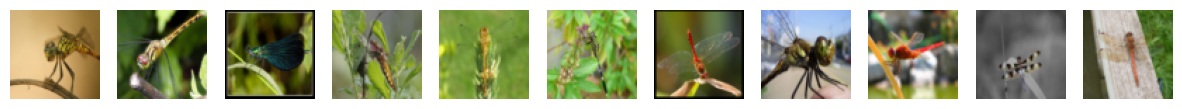

In [100]:
# Check the length of the dataset
print(f"Length of the dataset: {len(dataset)}")

# Visualize some images from the dataset
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Get an image from the dataset
        image = dataset[i]["pixel_values"]  # Access the preprocessed tensor
        # Convert tensor to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        axes[i].imshow(image)
        axes[i].axis("off")
    plt.show()

# Visualize 5 images
visualize_images(dataset, num_images=11)

## Generate images from the trained model

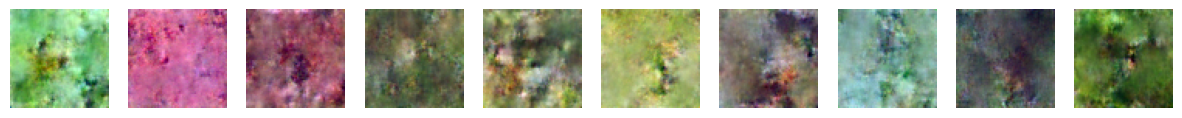

In [101]:
import torch
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import matplotlib.pyplot as plt

# Load the trained model
model = UNet2DModel(
    sample_size=64,  # Match the image size used during training
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

# Load the saved model weights
model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()  # Set the model to evaluation mode

# Set up the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Function to generate images
def generate_images(num_images=1):
    with torch.no_grad():  # Disable gradient computation
        # Start from random noise
        noise = torch.randn((num_images, 3, 64, 64)).to("cuda")  # Match input dimensions
        images = noise

        # Denoising loop
        for t in noise_scheduler.timesteps:
            # Predict the noise residual
            noise_pred = model(images, t).sample

            # Compute the previous noisy sample x_t-1
            images = noise_scheduler.step(noise_pred, t, images).prev_sample

        # Convert images to CPU and denormalize
        images = images.detach().cpu()
        images = (images * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        images = torch.clamp(images, 0, 1)  # Clamp to valid pixel range
        return images

# Generate and visualize images
num_images = 10
generated_images = generate_images(num_images)

# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

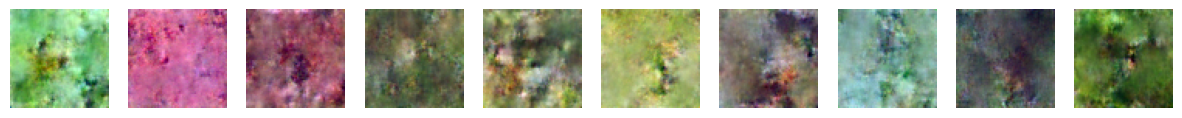

In [102]:
import os
from matplotlib import pyplot as plt

# Create a directory to save the images
os.makedirs("images", exist_ok=True)

# Plot and save the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")

    # Save each image with a zero-padded two-digit number
    filename = f"images/animal_{i:02d}.png"
    plt.imsave(filename, img.numpy())

# Save the entire grid of images
plt.savefig("images/animal_grid.png")
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [103]:
# !rm -rf images/

# Utility to zip a file
import shutil
shutil.make_archive("animals", "zip", "images")

'/content/animals.zip'